In [ ]:
# import libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.image import imread

import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sympy.polys.domains.finitefield import flint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPool2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load data

# via : https://www.kaggle.com/datasets/kmader/rsna-bone-age/datahttps://www.kaggle.com/datasets/kmader/rsna-bone-age/data

df_direction = 'res'

training_df = pd.read_csv('res/boneage-training-dataset.csv')

In [ ]:
training_df['path'] = (training_df['id'].map(lambda id: os.path.join
(df_direction, 'boneage-training-dataset','boneage-training-dataset',f'{id}.png')))
training_df.head()

In [ ]:
training_df['img_path'] = (training_df['id'].map(lambda id: f'{id}.png'))
training_df['img_path']

In [ ]:
training_df['gender'] = training_df['male'].map(lambda x: 'male' if x == 1 else 'female')
training_df['gender']

In [ ]:
training_df['gender_encoded'] = training_df['gender'].map(lambda x: 1 if x == 'male' else 0)


In [ ]:
training_df['boneage_category'] = pd.cut(training_df['boneage'],10)


In [ ]:
boneage_std = 2*training_df['boneage'].std()
boneage_mean = training_df['boneage'].mean()
print(boneage_std, boneage_mean)

In [ ]:
training_df['norm_age'] = (training_df['boneage'] - boneage_mean) / boneage_mean


In [18]:
test_df = pd.read_csv('res/boneage-test-dataset.csv')

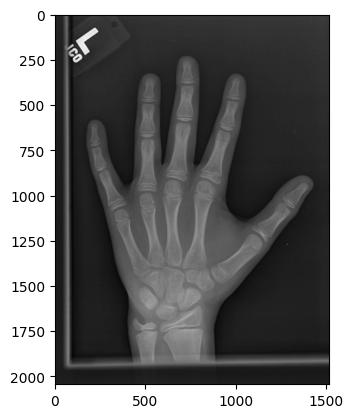

In [20]:
# visualization
single_img = training_df['path'][11]
img = imread(single_img)

plt.imshow(img, cmap='gray')

In [33]:
# preprocessing : train-test split, data augmentation

df_train, df_validation = train_test_split(training_df, test_size=0.2, random_state=42, shuffle=True)

df_val, df_test = train_test_split(df_validation, test_size=0.5, random_state=42, shuffle=True)


In [26]:
# data augmentation

data_augmentation = dict(rotation_range=180,
                                       zoom_range=0.2,
                                       brightness_range=[0.2, 0.5],
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.05,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

In [27]:
# ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255,
                                     preprocessing_function=preprocess_input, **data_augmentation)
test_val_generator = ImageDataGenerator(rescale=1/255, preprocessing_function=preprocess_input)

In [30]:
img_size = (256,256)
batch_size = 128

train_data = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='other', # regression problem
    flip_vert=True,
    color_mode='rgb',
    target_size=img_size
)

Found 10088 validated image filenames.


In [34]:
valid_data = test_val_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col= 'path',
    y_col='boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='other',
    flip_vert=True,
    color_mode='rgb',
    target_size=img_size
)

test_data = test_val_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col= 'path',
    y_col='boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='other',
    flip_vert=True,
    color_mode='rgb',
    target_size=img_size
)

Found 1261 validated image filenames.
Found 1262 validated image filenames.


In [ ]:
X_test , y_test = next(test_val_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col= 'path',
    y_col='boneage',
    batch_size=batch_size * 10,
    class_mode='other',
    flip_vert=True,
    color_mode='rgb',
    target_size=img_size
    
))